/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:94: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:95: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


788538060000.0


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:104: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


16668464000.0
6206644700.0
3540520200.0
2385335300.0
1742518100.0
1347996300.0
1089836500.0
910712060.0
779791900.0


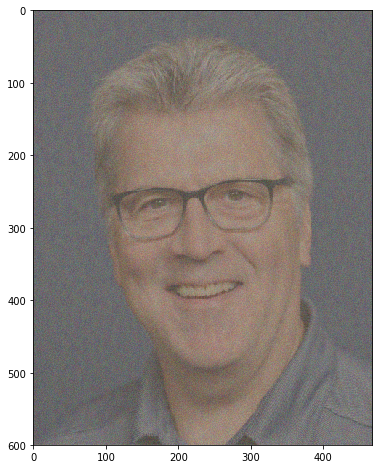

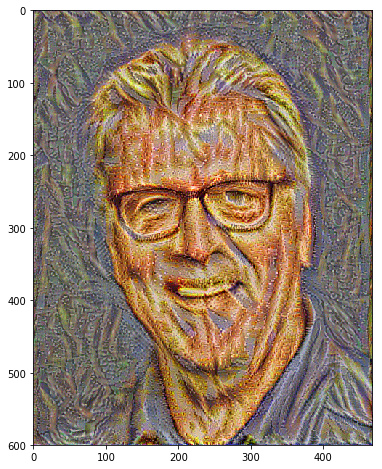

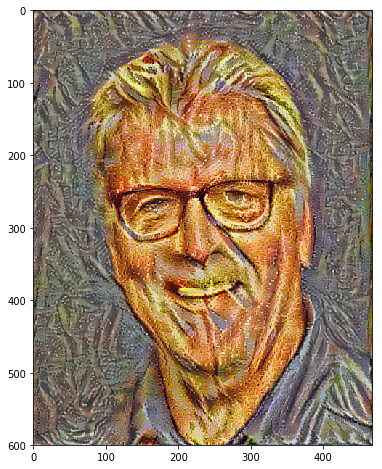

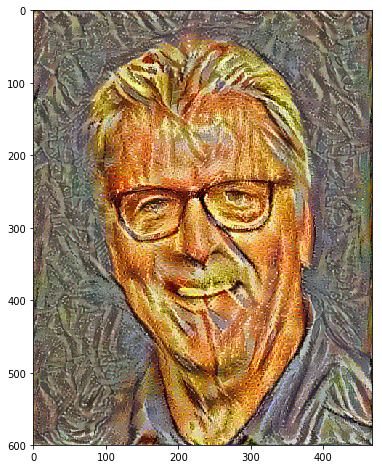

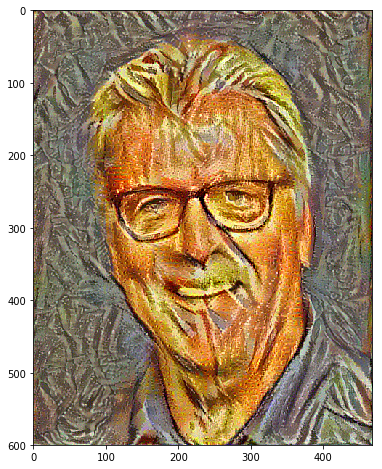

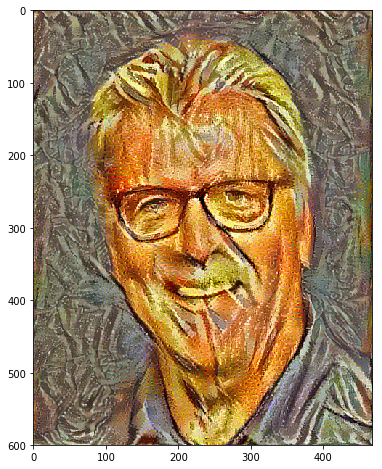

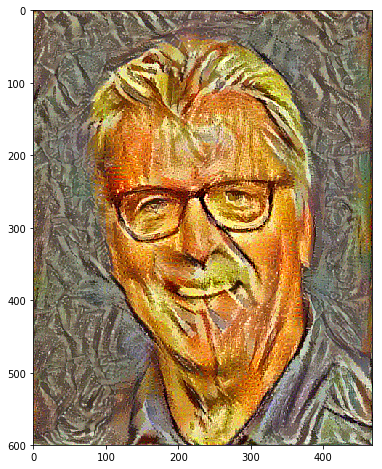

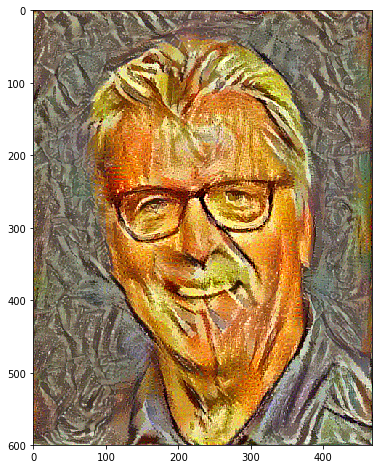

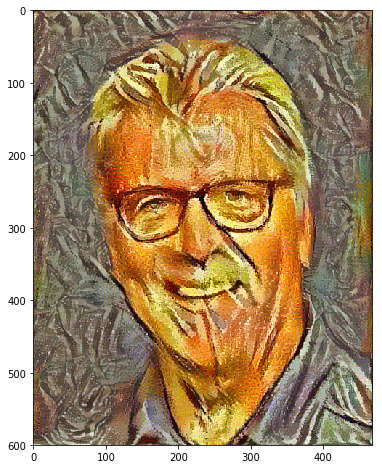

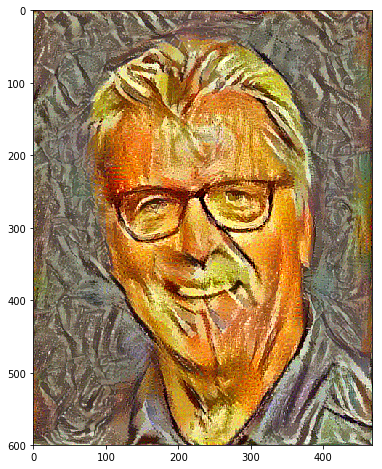

In [10]:
import tensorflow as tf
import numpy as np
import scipy.io
import scipy.misc
import os

IMAGE_W = 800
IMAGE_H = 600 
CONTENT_IMG =  './images/Taipei101.jpg'
STYLE_IMG = './images/StarryNight.jpg'
OUTOUT_DIR = './results'
OUTPUT_IMG = 'results.png'
VGG_MODEL = 'imagenet-vgg-verydeep-19.mat'
INI_NOISE_RATIO = 0.7
STYLE_STRENGTH = 500
ITERATION = 5000

CONTENT_LAYERS =[('conv4_2',1.)]
STYLE_LAYERS=[('conv1_1',1.),('conv2_1',1.),('conv3_1',1.),('conv4_1',1.),('conv5_1',1.)]


MEAN_VALUES = np.array([123, 117, 104]).reshape((1,1,1,3))

def build_net(ntype, nin, nwb=None):
  if ntype == 'conv':
    return tf.nn.relu(tf.nn.conv2d(nin, nwb[0], strides=[1, 1, 1, 1], padding='SAME')+ nwb[1])
  elif ntype == 'pool':
    return tf.nn.avg_pool(nin, ksize=[1, 2, 2, 1],
                  strides=[1, 2, 2, 1], padding='SAME')

def get_weight_bias(vgg_layers, i,):
  weights = vgg_layers[i][0][0][0][0][0]
  weights = tf.constant(weights)
  bias = vgg_layers[i][0][0][0][0][1]
  bias = tf.constant(np.reshape(bias, (bias.size)))
  return weights, bias

def build_vgg19(path):
  net = {}
  vgg_rawnet = scipy.io.loadmat(path)
  vgg_layers = vgg_rawnet['layers'][0]
  net['input'] = tf.Variable(np.zeros((1, IMAGE_H, IMAGE_W, 3)).astype('float32'))
  net['conv1_1'] = build_net('conv',net['input'],get_weight_bias(vgg_layers,0))
  net['conv1_2'] = build_net('conv',net['conv1_1'],get_weight_bias(vgg_layers,2))
  net['pool1']   = build_net('pool',net['conv1_2'])
  net['conv2_1'] = build_net('conv',net['pool1'],get_weight_bias(vgg_layers,5))
  net['conv2_2'] = build_net('conv',net['conv2_1'],get_weight_bias(vgg_layers,7))
  net['pool2']   = build_net('pool',net['conv2_2'])
  net['conv3_1'] = build_net('conv',net['pool2'],get_weight_bias(vgg_layers,10))
  net['conv3_2'] = build_net('conv',net['conv3_1'],get_weight_bias(vgg_layers,12))
  net['conv3_3'] = build_net('conv',net['conv3_2'],get_weight_bias(vgg_layers,14))
  net['conv3_4'] = build_net('conv',net['conv3_3'],get_weight_bias(vgg_layers,16))
  net['pool3']   = build_net('pool',net['conv3_4'])
  net['conv4_1'] = build_net('conv',net['pool3'],get_weight_bias(vgg_layers,19))
  net['conv4_2'] = build_net('conv',net['conv4_1'],get_weight_bias(vgg_layers,21))
  net['conv4_3'] = build_net('conv',net['conv4_2'],get_weight_bias(vgg_layers,23))
  net['conv4_4'] = build_net('conv',net['conv4_3'],get_weight_bias(vgg_layers,25))
  net['pool4']   = build_net('pool',net['conv4_4'])
  net['conv5_1'] = build_net('conv',net['pool4'],get_weight_bias(vgg_layers,28))
  net['conv5_2'] = build_net('conv',net['conv5_1'],get_weight_bias(vgg_layers,30))
  net['conv5_3'] = build_net('conv',net['conv5_2'],get_weight_bias(vgg_layers,32))
  net['conv5_4'] = build_net('conv',net['conv5_3'],get_weight_bias(vgg_layers,34))
  net['pool5']   = build_net('pool',net['conv5_4'])
  return net

def build_content_loss(p, x):
  M = p.shape[1]*p.shape[2]
  N = p.shape[3]
  loss = (1./(2* N**0.5 * M**0.5 )) * tf.reduce_sum(tf.pow((x - p),2))  
  return loss


def gram_matrix(x, area, depth):
  x1 = tf.reshape(x,(area,depth))
  g = tf.matmul(tf.transpose(x1), x1)
  return g

def gram_matrix_val(x, area, depth):
  x1 = x.reshape(area,depth)
  g = np.dot(x1.T, x1)
  return g

def build_style_loss(a, x):
  M = a.shape[1]*a.shape[2]
  N = a.shape[3]
  A = gram_matrix_val(a, M, N )
  G = gram_matrix(x, M, N )
  loss = (1./(4 * N**2 * M**2)) * tf.reduce_sum(tf.pow((G - A),2))
  return loss



def read_image(path):
  image = scipy.misc.imread(path)
  image = scipy.misc.imresize(image,(IMAGE_H,IMAGE_W))
  image = image[np.newaxis,:,:,:] 
  image = image - MEAN_VALUES
  return image

def write_image(path, image):
  image = image + MEAN_VALUES
  image = image[0]
  image = np.clip(image, 0, 255).astype('uint8')
  scipy.misc.imsave(path, image)

def show_image(image):
    import matplotlib.pyplot as plt
    image = image + MEAN_VALUES
    image = image[0]
    image = np.clip(image, 0, 255).astype('uint8')

    i = np.reshape(image, (IMAGE_H, IMAGE_W, -1))
    fig = plt.figure(figsize=(20,8))
    ax2 = fig.add_subplot(1,2,2)

    i = ax2.imshow(i,interpolation='none')
    fig.show()

def main():
  net = build_vgg19(VGG_MODEL)
  sess = tf.Session()
  sess.run(tf.initialize_all_variables())
  noise_img = np.random.uniform(-20, 20, (1, IMAGE_H, IMAGE_W, 3)).astype('float32')
  content_img = read_image(CONTENT_IMG)
  style_img = read_image(STYLE_IMG)

  sess.run([net['input'].assign(content_img)])
  cost_content = sum(map(lambda l,: l[1]*build_content_loss(sess.run(net[l[0]]) ,  net[l[0]])
    , CONTENT_LAYERS))

  sess.run([net['input'].assign(style_img)])
  cost_style = sum(map(lambda l: l[1]*build_style_loss(sess.run(net[l[0]]) ,  net[l[0]])
    , STYLE_LAYERS))

  cost_total = cost_content + STYLE_STRENGTH * cost_style
  optimizer = tf.train.AdamOptimizer(2.0)

  train = optimizer.minimize(cost_total)
  sess.run(tf.initialize_all_variables())
  sess.run(net['input'].assign( INI_NOISE_RATIO* noise_img + (1.-INI_NOISE_RATIO) * content_img))

  if not os.path.exists(OUTOUT_DIR):
      os.mkdir(OUTOUT_DIR)

  for i in range(ITERATION):
    sess.run(train)
    if i%100 ==0:
      result_img = sess.run(net['input'])
      print sess.run(cost_total)
      show_image(result_img)
      write_image(os.path.join(OUTOUT_DIR,'%s.png'%(str(i).zfill(4))),result_img)
  
  write_image(os.path.join(OUTOUT_DIR,OUTPUT_IMG),result_img)
  

if __name__ == '__main__':
  main()
